# LV3 - Klasifikacija teksta pomoću strojnog učenja



## Ciljevi laboratorijske vježbe:


*   Pripremiti označene skupove podataka za klasifikaciju teksta
*   Trenirati klasifikator
*   Evaluirati performanse klasifikatora (točnost, preciznost, odziv)



## 1. Instalacija biblioteka

In [1]:
from google.colab import files
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay
import numpy as np

## 2. Učitavanje dataseta Coronavirus tweets NLP - Text Classification

Potrebno je preuzeti javni dataset s platforme Kaggle. Kako bi preuzimanje bilo uspješno, potrebno je preuzeti datoteku `kaggle.json` sa svog Kaggle korisničkog profila i uploadati ju prilikom izvođenja sljedećeg programskog koda. Moguće je i preuzeti dataset i prenijeti ga u Google Colab ručno. Dataset možete preuzeti na [linku](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification).



In [2]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle
!kaggle datasets download -d datatattle/covid-19-nlp-text-classification

Saving Corona_NLP_test.csv to Corona_NLP_test.csv
Saving Corona_NLP_train.csv to Corona_NLP_train.csv
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [3]:
#!unzip covid-19-nlp-text-classification.zip -d covid_dataset

# Ovaj dataset dolazi kodiran u ISO-8859-1 (Latin-1), pa je potrebno specificirati encoding parametar
train = pd.read_csv("Corona_NLP_train.csv", encoding="latin1")
test = pd.read_csv("Corona_NLP_test.csv", encoding="latin1")

train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## 3. Priprema podataka



### a) Odabir značajki

In [4]:
selected_features_train = train[['OriginalTweet', 'Sentiment']]
selected_features_test = test[['OriginalTweet', 'Sentiment']]

### b) Provjera nedostajućih vrijednosti

In [5]:
print(selected_features_train.shape[0])
print(f"Broj nedostajućih vrijednosti:\n{selected_features_train.isnull().sum()}")

41157
Broj nedostajućih vrijednosti:
OriginalTweet    0
Sentiment        0
dtype: int64


Budući da stupac Location neće biti korišten pri treniranju modela, nedostajuće vrijednosti se mogu zanemariti.

In [6]:
# ZADATAK: Provjerite nedostajuće vrijednosti u testnom skupu te riješite na prikladan način ukoliko ih ima

print(test.isnull().sum())

if test['OriginalTweet'].isnull().sum() > 0:
    test['OriginalTweet'] = test['OriginalTweet'].fillna("")

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64


Sentiment
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: count, dtype: int64


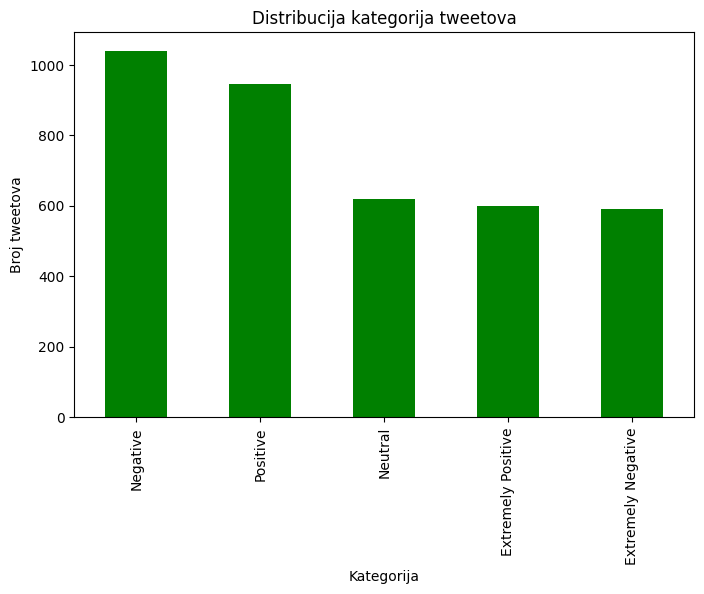

In [7]:
# ZADATAK: Provjerite broj ponavljanja svake od kategorija tweetova te ih prikžite na grafu koristeći prikladne biblioteke

counts = test['Sentiment'].value_counts()
print(counts)

plt.figure(figsize=(8,5))
counts.plot(kind='bar', color="green")
plt.xlabel("Kategorija")
plt.ylabel("Broj tweetova")
plt.title("Distribucija kategorija tweetova")
plt.show()

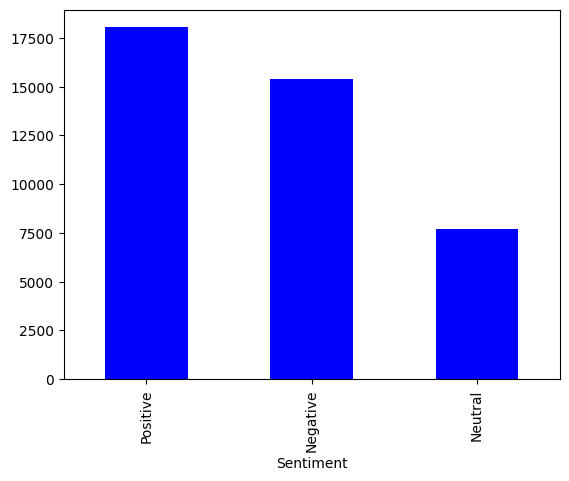

In [9]:
mapping = {
    'Positive': 'Positive',
    'Extremely Positive': 'Positive',
    'Negative': 'Negative',
    'Extremely Negative': 'Negative',
    'Neutral': 'Neutral'
}

selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
selected_features_test['Sentiment'] = selected_features_test['Sentiment'].map(mapping)

# ZADATAK: Prikažite broj primjeraka u svakoj klasi nakon mapiranja

selected_features_train = train[['Sentiment', 'OriginalTweet']].copy()
selected_features_test  = test[['Sentiment', 'OriginalTweet']].copy()

mapping = {
    'Positive': 'Positive',
    'Extremely Positive': 'Positive',
    'Negative': 'Negative',
    'Extremely Negative': 'Negative',
    'Neutral': 'Neutral'
}

selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
selected_features_test['Sentiment']  = selected_features_test['Sentiment'].map(mapping)

selected_features_train['Sentiment'].value_counts()

selected_features_train['Sentiment'].value_counts().plot(kind='bar', color="blue")
plt.show()

### c) Lematizacija i čišćenje teksta

In [10]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [12]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatize_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [w for w in tokens if w.isalpha() and w not in stop_words]
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(lemmas)

selected_features_train['clean_tweet'] = selected_features_train['OriginalTweet'].apply(lemmatize_text).apply(clean_text)
selected_features_test['clean_tweet'] = selected_features_test['OriginalTweet'].apply(lemmatize_text).apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### d) Pretvaranje teksta u vektore značajki (TF-IDF)

TF-IDF (Term Frequency–Inverse Document Frequency) je statistička metoda koja se koristi u obradi prirodnog jezika i pretraživanju informacija za procjenu koliko je određena riječ važna za jedan dokument u odnosu na veću zbirku dokumenata. TF-IDF kombinira dvije komponente:
1. Frekvencija pojma (TF): Mjeri koliko se puta riječ pojavljuje u dokumentu. Veća učestalost sugerira veću važnost. Ako se neki pojam često pojavljuje u dokumentu, vjerojatno je relevantan za sadržaj tog dokumenta.
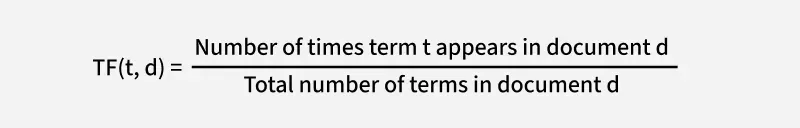

2. Obrnuta frekvencija dokumenta (IDF): Smanjuje težinu uobičajenih riječi koje se pojavljuju u više dokumenata, dok povećava težinu rijetkih riječi. Ako se pojam pojavljuje u manjem broju dokumenata, veća je vjerojatnost da je značajan i specifičan.
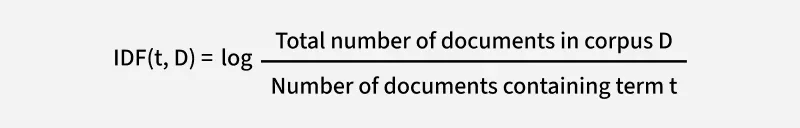

Ova ravnoteža omogućuje TF-IDF-u da istakne pojmove koji su i učestali unutar određenog dokumenta i prepoznatljivi u odnosu na ostatak zbirke dokumenata, što ga čini korisnim alatom za zadatke poput rangiranja pretraživanja, klasifikacije teksta i izdvajanja ključnih riječi.

In [13]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

X_train = tfidf.fit_transform(selected_features_train['clean_tweet'])
# ZADATAK: Transformirati očišćene tekstualne tweetove u numeričku TF-IDF reprezentaciju na testnom skupu.

X_test = tfidf.transform(selected_features_test['clean_tweet'])

### e) Enkodiranje oznaka

In [14]:
le = LabelEncoder()

print(selected_features_train['Sentiment'].unique())

y_train = le.fit_transform(selected_features_train['Sentiment'])
y_test = le.transform(selected_features_test['Sentiment'])

y_train = pd.DataFrame(y_train, columns=['Sentiment'])
y_test = pd.DataFrame(y_test, columns=['Sentiment'])
y_train.head()

['Neutral' 'Positive' 'Negative']


,Sentiment
0,1
1,2
2,2
3,2
4,0


## 4. Treniranje modela - Naive Bayes

In [15]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(MultinomialNB(), param_grid, cv=skf, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best alpha: {'alpha': 0.1}
Best cross-val accuracy: 0.6776249663653926


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [16]:
model = MultinomialNB(alpha = 0.1)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=0.1)

## 5. Evaluacija performansi

In [17]:
y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.72      0.72      0.72      1633
     Neutral       0.62      0.19      0.29       619
    Positive       0.63      0.80      0.71      1546

    accuracy                           0.67      3798
   macro avg       0.66      0.57      0.58      3798
weighted avg       0.67      0.67      0.65      3798

Confusion Matrix:

[[1183   50  400]
 [ 181  120  318]
 [ 278   25 1243]]


## ZADATAK:
Trenirati model koristeći SVM i usporediti performanse s Naive Bayes-om.

In [18]:
y_train = selected_features_train['Sentiment']
y_test = selected_features_test['Sentiment']

svm_clf = LinearSVC()
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

print("SVM točnost:", accuracy_score(y_test, y_pred_svm))
print("SVM izvještaj:")
print(classification_report(y_test, y_pred_svm))

nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)
y_pred_nb = nb_clf.predict(X_test)

print("Naive Bayes točnost:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes izvještaj:")
print(classification_report(y_test, y_pred_nb))

SVM točnost: 0.7859399684044234
SVM izvještaj:
              precision    recall  f1-score   support

    Negative       0.82      0.79      0.80      1633
     Neutral       0.67      0.65      0.66       619
    Positive       0.80      0.84      0.82      1546

    accuracy                           0.79      3798
   macro avg       0.76      0.76      0.76      3798
weighted avg       0.79      0.79      0.79      3798

Naive Bayes točnost: 0.6656134807793576
Naive Bayes izvještaj:
              precision    recall  f1-score   support

    Negative       0.73      0.72      0.72      1633
     Neutral       0.62      0.15      0.24       619
    Positive       0.62      0.82      0.71      1546

    accuracy                           0.67      3798
   macro avg       0.66      0.56      0.55      3798
weighted avg       0.67      0.67      0.64      3798



# Zadatak – samostalan rad na datasetu

### U ovom zadatku studenti će sami proći cijeli proces klasifikacije teksta koristeći metode strojnog učenja – od pripreme podataka do treniranja i usporedbe različitih modela.

Cilj je klasificirati opise proizvoda iz e-trgovine u jednu od četiri kategorije (Electronics, Household, Books, Clothing & Accessories).

### Koraci zadatka:

1. **Pregled dataseta**  
   - Preuzmite dataset „E-commerce Text Classification“ s Kaggle-a:  
     https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification  
   - Učitajte ga u Colab (npr. pomoću `pd.read_csv`)  
   - Prikažite osnovne informacije o datasetu

2. **Odabir značajki i čišćenje podataka**  
   - Provjerite i obradite nedostajuće vrijednosti
   - Uklonite duplikate ako postoje  
   - Po potrebi uravnotežite dataset (npr. undersampling/oversampling) – nije obavezno, ali je plus

3. **Predobrada teksta (čišćenje i lematizacija)**  
   - Pretvorite tekst u mala slova  
   - Uklonite HTML tagove, URL-ove, interpunkciju, brojeve, specijalne znakove  
   - Uklonite stop-riječi  
   - Provedite lematizaciju

4. **Pretvaranje teksta u vektore značajki**  
     - `TfidfVectorizer`
   - Podijelite podatke na train/test skup (80/20 ili 75/25)

5. **Enkodiranje oznaka (labela)**  
   - Pretvorite tekstualne kategorije u brojčane pomoću `LabelEncoder` ili `OneHotEncoder` (ovisno o modelu)

6. **Treniranje i usporedba modela**  
   
   
   Za svaki model:
   - Naučite model na trening skupu
   - Izmjerite performanse na test skupu: **accuracy, precision, recall, F1-score**
   - Nacrtajte **confusion matrix** i **classification report**
   - Ako stignete: Podesite hiperparametre (barem `GridSearchCV` ili `RandomizedSearchCV` na 2–3 parametra) za bolje rezultate

7. **Vizualizacija rezultata**  
   - Usporedite dva (ili više) modela u tablici i stupčastim grafom (accuracy, F1-score)
   
   - Ako koristite TF-IDF, pokažite 10–20 riječi s najvećim TF-IDF težinama po klasi (Iz riječi biste trebali zaključiti o kojoj klasi se radi)

8. **Zaključak i komentar rezultata**  
   - Koji model je bio bolji i zašto?
   - Koje su prednosti i nedostaci pristupa koje ste koristili?
   - Što biste još mogli isprobati da poboljšate rezultat (ideje za daljnje eksperimente)?
   - Koliko je predobrada teksta utjecala na performanse?


In [20]:
#Zadatak 1
df = pd.read_csv(
    "ecommerceDataset.csv",
    engine="python",
    header=None,
    on_bad_lines="skip"
)

df.columns = ["Category", "Text"]

print("Prvih 5 redaka:")
display(df.head())

print("\nInfo o stupcima:")
print(df.info())

print("\nBroj primjera po klasi:")
print(df["Category"].value_counts())

Prvih 5 redaka:


,Category,Text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...



Info o stupcima:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  50425 non-null  object
 1   Text      50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB
None

Broj primjera po klasi:
Category
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64


In [22]:
#Zadatak 2

print("\nNedostajuce vrijednosti:")
print(df.isnull().sum())

df = df.dropna(subset=["Category", "Text"])

print("\nDuplikati prije:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplikati poslije:", df.duplicated().sum())

min_count = df["Category"].value_counts().min()
balanced_parts = []

for cat, group in df.groupby("Category"):
    balanced_parts.append(group.sample(min_count, random_state=42))

df_balanced = pd.concat(balanced_parts).sample(frac=1, random_state=42).reset_index(drop=True)

print("\nBroj primjera po klasi nakon balansa:")
print(df_balanced["Category"].value_counts())


Nedostajuce vrijednosti:
Category    0
Text        0
dtype: int64

Duplikati prije: 0
Duplikati poslije: 0

Broj primjera po klasi nakon balansa:
Category
Books                     5308
Electronics               5308
Household                 5308
Clothing & Accessories    5308
Name: count, dtype: int64


In [23]:
#Zadatak 3
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()

    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)

    text = re.sub(r'[^a-z\s]', ' ', text)

    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]

    lemmas = [lemmatizer.lemmatize(w) for w in tokens]

    return " ".join(lemmas)

df_balanced["clean_text"] = df_balanced["Text"].apply(preprocess_text)

df_balanced[["Text", "clean_text"]].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,Text,clean_text
0,"Crazy Rich Asians (Film Tie-in) Review Shrewd,...",crazy rich asian film tie review shrewd funny ...
1,CamArmour Flexible Octopus Foldable Tripod for...,camarmour flexible octopus foldable tripod cam...
2,eKlasse EKBTEP15XM Bluetooth Sports Headset (B...,eklasse ekbtep xm bluetooth sport headset blac...
3,Xam Idea Complete Course Science Class 10 for ...,xam idea complete course science class exam
4,RETAILSHOPPING Anycast Chromecast HDMI 1080P E...,retailshopping anycast chromecast hdmi p ez ca...


In [24]:
#Zadatak 4
X = df_balanced["clean_text"]
y = df_balanced["Category"]

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    sublinear_tf=True
)

X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

In [25]:
#Zadatak 5
label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)

y_test_enc = label_encoder.transform(y_test)

print("Izvorne klase:", label_encoder.classes_)
print("Primjeri enkodiranih:", y_train_enc[:10])

Izvorne klase: ['Books' 'Clothing & Accessories' 'Electronics' 'Household']
Primjeri enkodiranih: [2 3 1 3 0 0 3 1 3 1]



=== Linear SVM ===
Accuracy:  0.9588
Precision: 0.9590
Recall:    0.9588
F1-score:  0.9588

Classification report:
                        precision    recall  f1-score   support

                 Books       0.97      0.94      0.95      1062
Clothing & Accessories       0.98      0.98      0.98      1061
           Electronics       0.96      0.95      0.95      1062
             Household       0.94      0.97      0.95      1062

              accuracy                           0.96      4247
             macro avg       0.96      0.96      0.96      4247
          weighted avg       0.96      0.96      0.96      4247



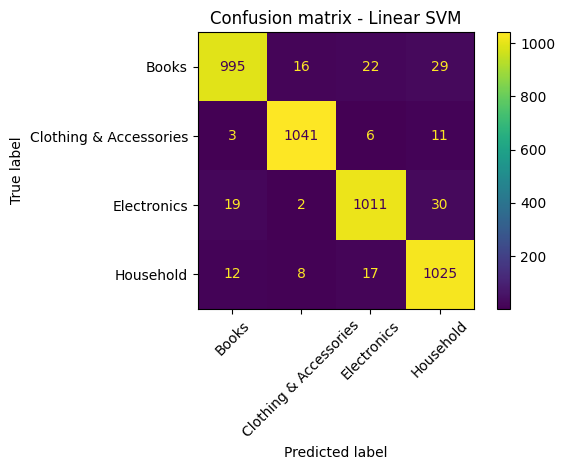


=== Multinomial Naive Bayes ===
Accuracy:  0.9456
Precision: 0.9468
Recall:    0.9456
F1-score:  0.9457

Classification report:
                        precision    recall  f1-score   support

                 Books       0.97      0.91      0.94      1062
Clothing & Accessories       0.96      0.97      0.97      1061
           Electronics       0.96      0.94      0.95      1062
             Household       0.90      0.96      0.93      1062

              accuracy                           0.95      4247
             macro avg       0.95      0.95      0.95      4247
          weighted avg       0.95      0.95      0.95      4247



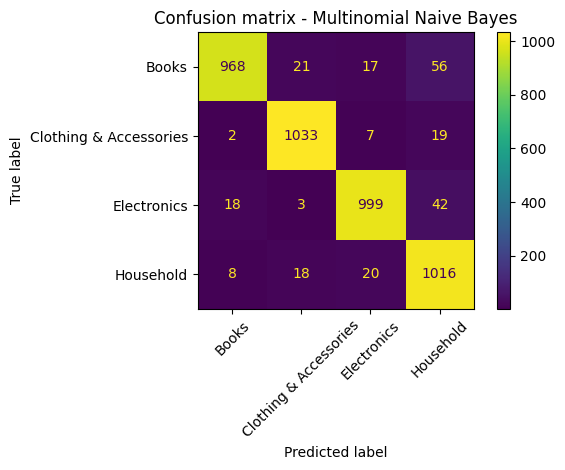


=== Logistic Regression ===
Accuracy:  0.9520
Precision: 0.9525
Recall:    0.9520
F1-score:  0.9520

Classification report:
                        precision    recall  f1-score   support

                 Books       0.96      0.94      0.95      1062
Clothing & Accessories       0.97      0.98      0.97      1061
           Electronics       0.96      0.94      0.95      1062
             Household       0.92      0.96      0.94      1062

              accuracy                           0.95      4247
             macro avg       0.95      0.95      0.95      4247
          weighted avg       0.95      0.95      0.95      4247



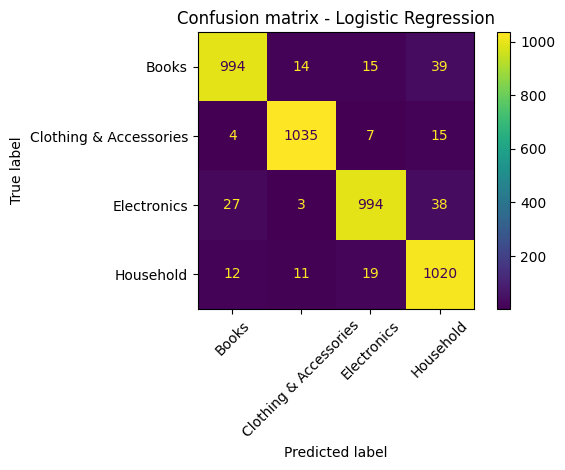


Najbolji SVM hiperparametri: {'C': 1.0, 'class_weight': None}
Najbolji CV F1-macro: 0.9546229627412665

=== Best SVM (GridSearch) ===
Accuracy:  0.9581
Precision: 0.9583
Recall:    0.9581
F1-score:  0.9581

Classification report:
                        precision    recall  f1-score   support

                 Books       0.97      0.94      0.95      1062
Clothing & Accessories       0.97      0.98      0.98      1061
           Electronics       0.96      0.95      0.95      1062
             Household       0.94      0.96      0.95      1062

              accuracy                           0.96      4247
             macro avg       0.96      0.96      0.96      4247
          weighted avg       0.96      0.96      0.96      4247



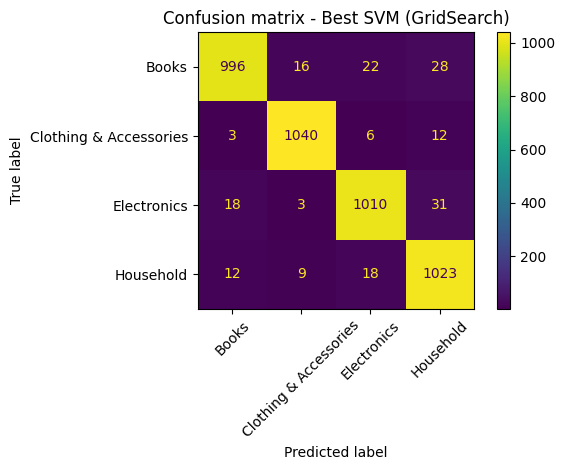

In [26]:
#Zadatak 6
def evaluate_model(name, model, X_train, y_train, X_test, y_test, class_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro"
    )

    print(f"\n=== {name} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}\n")
    print("Classification report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45)
    plt.title(f"Confusion matrix - {name}")
    plt.tight_layout()
    plt.show()

class_names = label_encoder.classes_

svm_clf = LinearSVC(C=1.5)
evaluate_model("Linear SVM", svm_clf, X_train, y_train_enc, X_test, y_test_enc, class_names)

nb_clf = MultinomialNB(alpha=0.3)
evaluate_model("Multinomial Naive Bayes", nb_clf, X_train, y_train_enc, X_test, y_test_enc, class_names)

log_reg = LogisticRegression(max_iter=2000)
evaluate_model("Logistic Regression", log_reg, X_train, y_train_enc, X_test, y_test_enc, class_names)

param_grid = {
    "C": [0.5, 1.0, 1.5, 2.0],
    "class_weight": [None, "balanced"],
}

grid_svm = GridSearchCV(
    LinearSVC(),
    param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
)

grid_svm.fit(X_train, y_train_enc)
print("\nNajbolji SVM hiperparametri:", grid_svm.best_params_)
print("Najbolji CV F1-macro:", grid_svm.best_score_)

best_svm = grid_svm.best_estimator_
evaluate_model("Best SVM (GridSearch)", best_svm, X_train, y_train_enc, X_test, y_test_enc, class_names)

                 Model  Accuracy  F1_macro
0           Linear SVM  0.958794  0.958787
1          Naive Bayes  0.945609  0.945714
2  Logistic Regression  0.951966  0.952019


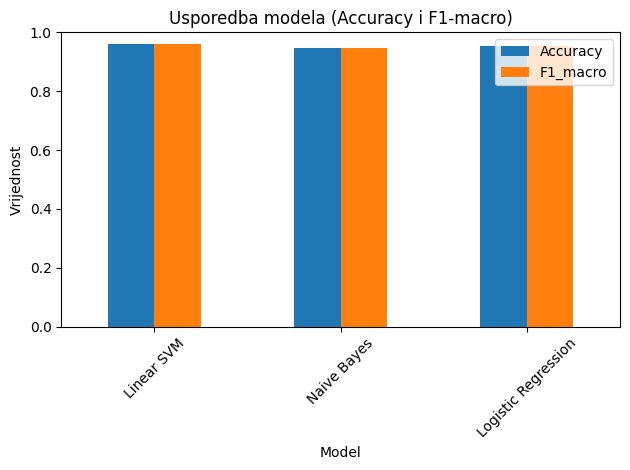


Top 10 riječi za klasu 'Books':
author, fishing, book, boating, skateboard, canoeing, climbing, toreto, training, family

Top 10 riječi za klasu 'Clothing & Accessories':
woman, men, sunglass, bra, boy, girl, sock, headband, cotton, unisex

Top 10 riječi za klasu 'Electronics':
camera, laptop, screen, lens, gb, mount, cable, projector, trail, correction

Top 10 riječi za klasu 'Household':
bathrobe, door, vacuum, chair, oven, latch, paint, curtain, home, album


In [27]:
#Zadatak 7
results = []

models = [
    ("Linear SVM", svm_clf),
    ("Naive Bayes", nb_clf),
    ("Logistic Regression", log_reg),
]

for name, model in models:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    f1 = f1_score(y_test_enc, y_pred, average="macro")
    results.append({"Model": name, "Accuracy": acc, "F1_macro": f1})

results_df = pd.DataFrame(results)
print(results_df)

ax = results_df.set_index("Model")[["Accuracy", "F1_macro"]].plot(kind="bar")
plt.ylim(0, 1)
plt.ylabel("Vrijednost")
plt.title("Usporedba modela (Accuracy i F1-macro)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


feature_names = tfidf.get_feature_names_out()
class_labels = label_encoder.classes_
top_n = 10

for i, class_name in enumerate(class_labels):
    class_coef = svm_clf.coef_[i]
    top_indices = np.argsort(class_coef)[-top_n:][::-1]
    top_words = [feature_names[j] for j in top_indices]

    print(f"\nTop {top_n} riječi za klasu '{class_name}':")
    print(", ".join(top_words))
